
![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Welcome to the eWaterCycle experiment notebook

In this notebook Wflow is being used to plot future discharge levels on the Rhine in the two critical places Kaub and Maxau Germany. These are based on using 3 climate scenarios: SSP1-2.6, SSP2-4.5 and SSP5-8.5, with the climate model a variable of choice.\
To run this notebook, you first have to create CMIP6 forcing data using the CMIP6_forcing_Rhine_Kaub_Maxau notebook for the three scenarios. \
This forcing data is stored in the same file directory as this notebook, to use it, simply enter name of the generated json file the specified code.
This notebook works only in a timespan of more than two months, as the first two months are needed for the spinup for this model and thus discharges are not correct for those months. This model only runs on the specified timespan of the forcing from the generated CMIP6 data. 


In this notebook we run a hydrology model using [ewayercycle](https://github.com/eWaterCycle/ewatercycle).

In [1]:
from rich import print
import json
import pandas as pd
from pathlib import Path
import logging
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger("esmvalcore")
logger.setLevel(logging.WARNING)

from ewatercycle import CFG
import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets
import ewatercycle.analysis
from ewatercycle.testing.fixtures import rhine_shape

OSError: [Errno 5] Input/output error: '/mnt/data/observation/grdc/dailies'

## Load parameter set
Enter the name of the json file to load the forcing data paths from the CMIP6_forcing_Rhine_Kaub_Maxau notebook.

In [2]:
# Specify the file path of created json file
json_file_path = "forcing_data_CMIP6_wflow_2024-11-01 00:00:00_2050-12-31 00:00:00.json"

# Read data from JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

Load the start_time and end time used in the forcing data.

In [9]:
#Specified timespan used in forcing file
start_time=data['start_time']
end_time=data['end_time']

2024-11-01 00:00:00 2050-12-31 00:00:00

Loading the forcing and store them in this notebook.

In [4]:
# Forcing locations
forcing_locations = data['directories']

# List to store loaded forcings
forcings = []

# Loop to load the forcings and store them in the loaded forcings list
for i, location in enumerate(forcing_locations, 1):
    forcing = ewatercycle.forcing.sources["WflowForcing"].load(location)
    forcings.append(forcing)
    f'forcing_c{i} = {forcing}'

sets = ewatercycle.parameter_sets.available_parameter_sets(target_model="wflow")
parameter_set = sets["wflow_rhine_sbm_nc"]

NameError: name 'ewatercycle' is not defined

## Setting up the mode
In this piece of code the models are being initialized using the CMIP6 forcing data and the SSP-Pathways, they are stored in a list.\
There are some warnings when running this code, but you can ignore them.

In [6]:
# Load forcings
forcings = [ewatercycle.forcing.sources["WflowForcing"].load(location) for location in forcing_locations]

# List of model names
model_names = ['model_ssp126', 'model_ssp245', 'model_ssp585']

# List to store the models
models = {}

# Loop to initialize the models and store them
for i, (model_name, forcing) in enumerate(zip(model_names, forcings)):
    models[model_name] = ewatercycle.models.Wflow(
        version="2020.1.1",
        parameter_set=parameter_set,
        forcing=forcing,
        start_time=start_time,
        end_time=end_time
    )
    f'{model_name} = {models[model_name]}'

Current parameters of model.

In [7]:
models['model_ssp126'].parameters, models['model_ssp245'].parameters, models['model_ssp585'].parameters

(dict_items([('start_time', '2025-10-01T00:00:00Z'), ('end_time', '2050-12-31T00:00:00Z')]),
 dict_items([('start_time', '2025-10-01T00:00:00Z'), ('end_time', '2050-12-31T00:00:00Z')]),
 dict_items([('start_time', '2025-10-01T00:00:00Z'), ('end_time', '2050-12-31T00:00:00Z')]))

Pass one or more parameters with a custom value to the setup method to overwrite.

In [8]:
cfg_file_ssp126, cfg_dir_ssp126 = models['model_ssp126'].setup(end_time=end_time+'T00:00:00Z')
cfg_file_ssp245, cfg_dir_ssp245 = models['model_ssp245'].setup(end_time=end_time+'T00:00:00Z')
cfg_file_ssp585, cfg_dir_ssp585 = models['model_ssp585'].setup(end_time=end_time+'T00:00:00Z')

After setup the config file (`cfg_file`) can be edited if more customization is needed.

In [9]:
models['model_ssp126'].initialize(cfg_file_ssp126)
models['model_ssp245'].initialize(cfg_file_ssp245)
models['model_ssp585'].initialize(cfg_file_ssp585)

## Running the model

Get "RiverRunoff" at the coordinates from Kaub and Maxau locations.\
The model is simulating the discharges over the specified timespan and stores them into two dataframes, one for Kaub and one for Maxau.

In [10]:
grdc_longitude_kaub, grdc_latitude_kaub = 7.76115, 50.08813
grdc_longitude_maxau, grdc_latitude_maxau = 8.30259, 49.03700

In [11]:
simulated_discharge_kaub_ssp126, simulated_discharge_kaub_ssp245, simulated_discharge_kaub_ssp585 = [], [], []
simulated_discharge_maxau_ssp126, simulated_discharge_maxau_ssp245, simulated_discharge_maxau_ssp585 = [], [], []
timestamps_ssp126, timestamps_ssp245, timestamps_ssp585 = [], [], []

while models['model_ssp126'].time < models['model_ssp126'].end_time:
    models['model_ssp126'].update()
    discharge_kaub_ssp126 = models['model_ssp126'].get_value_at_coords("RiverRunoff", lat=[grdc_latitude_kaub], lon=[grdc_longitude_kaub])[0]
    discharge_maxau_ssp126 = models['model_ssp126'].get_value_at_coords("RiverRunoff", lat=[grdc_latitude_maxau], lon=[grdc_longitude_maxau])[0]
    simulated_discharge_kaub_ssp126.append(discharge_kaub_ssp126),
    simulated_discharge_maxau_ssp126.append(discharge_maxau_ssp126)
    timestamps_ssp126.append(models['model_ssp126'].time_as_datetime.date())
    simulated_discharge_kaub_ssp126, simulated_discharge_maxau_ssp126

while models['model_ssp245'].time < models['model_ssp245'].end_time:
    models['model_ssp245'].update()
    discharge_kaub_ssp245 = models['model_ssp245'].get_value_at_coords("RiverRunoff", lat=[grdc_latitude_kaub], lon=[grdc_longitude_kaub])[0]
    discharge_maxau_ssp245 = models['model_ssp245'].get_value_at_coords("RiverRunoff", lat=[grdc_latitude_maxau], lon=[grdc_longitude_maxau])[0]
    simulated_discharge_kaub_ssp245.append(discharge_kaub_ssp245),
    simulated_discharge_maxau_ssp245.append(discharge_maxau_ssp245)
    timestamps_ssp245.append(models['model_ssp245'].time_as_datetime.date())
    simulated_discharge_kaub_ssp245, simulated_discharge_maxau_ssp245

while models['model_ssp585'].time < models['model_ssp585'].end_time:
    models['model_ssp585'].update()
    discharge_kaub_ssp585 = models['model_ssp585'].get_value_at_coords("RiverRunoff", lat=[grdc_latitude_kaub], lon=[grdc_longitude_kaub])[0]
    discharge_maxau_ssp585 = models['model_ssp585'].get_value_at_coords("RiverRunoff", lat=[grdc_latitude_maxau], lon=[grdc_longitude_maxau])[0]
    simulated_discharge_kaub_ssp585.append(discharge_kaub_ssp585),
    simulated_discharge_maxau_ssp585.append(discharge_maxau_ssp585)
    timestamps_ssp585.append(models['model_ssp585'].time_as_datetime.date())
    simulated_discharge_kaub_ssp585, simulated_discharge_maxau_ssp585

In [12]:
simulated_discharge_kaub_ssp126_df, simulated_discharge_maxau_ssp126_df = pd.DataFrame({f"Simulation Kaub SSP1-2.6": simulated_discharge_kaub_ssp126}, index=pd.to_datetime(timestamps_ssp126)), pd.DataFrame({f"Simulation Maxau SSP1-2.6": simulated_discharge_maxau_ssp126}, index=pd.to_datetime(timestamps_ssp126))
simulated_discharge_kaub_ssp245_df, simulated_discharge_maxau_ssp245_df = pd.DataFrame({f"Simulation Kaub SSP2-4.5": simulated_discharge_kaub_ssp245}, index=pd.to_datetime(timestamps_ssp245)), pd.DataFrame({f"Simulation Maxau SSP2-4.5": simulated_discharge_maxau_ssp245}, index=pd.to_datetime(timestamps_ssp245))
simulated_discharge_kaub_ssp585_df, simulated_discharge_maxau_ssp585_df = pd.DataFrame({f"Simulation Kaub SSP5-8.5": simulated_discharge_kaub_ssp585}, index=pd.to_datetime(timestamps_ssp585)), pd.DataFrame({f"Simulation Maxau SSP5-8.5": simulated_discharge_maxau_ssp585}, index=pd.to_datetime(timestamps_ssp585))

Combine simulated pathways into a single dataframe

In [13]:
combined_discharge_kaub = simulated_discharge_kaub_ssp126_df.join(simulated_discharge_kaub_ssp245_df)
combined_discharge_maxau = simulated_discharge_maxau_ssp126_df.join(simulated_discharge_maxau_ssp245_df)
combined_discharge_kaub = combined_discharge_kaub.join(simulated_discharge_kaub_ssp585_df)
combined_discharge_maxau = combined_discharge_maxau.join(simulated_discharge_maxau_ssp585_df)

## Plotting graphs and removing first two months

As the spinup time of the model consists of around 2 months, the first two months will be skipped in the graphs

The first graphs will show the first year of simulating and the second row of graphs will show the last year of simulating:\
It also counts the amount of days that water discharge exceeds critical values of Kaub and Maxau

In [11]:
start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")

In [16]:
# Correcting timespan for plotting
start_time_graph = start_time + relativedelta(months=2)
first_end_time = start_time_graph + relativedelta(years=1) - relativedelta(days=1)
last_start_time = end_time - relativedelta(years=1) + relativedelta(days=1)
first_year = start_time_graph.strftime("%Y")
last_year = end_time.strftime("%Y")
print(start_time, start_time_graph, first_end_time, last_start_time, end_time)

2024-11-01 00:00:00 2025-01-01 00:00:00 2025-12-31 00:00:00 2050-01-01 00:00:00 2050-12-31 00:00:00

In [18]:
# Counting days that discharge is above or below critical level
timespan_maxau_ssp126_first, timespan_kaub_ssp126_first = simulated_discharge_maxau_ssp126_df[start_time_graph:first_end_time], simulated_discharge_kaub_ssp126_df[start_time_graph:first_end_time]
timespan_maxau_ssp126_last, timespan_kaub_ssp126_last = simulated_discharge_maxau_ssp126_df[last_start_time:end_time], simulated_discharge_kaub_ssp126_df[last_start_time:end_time]

Kaub_ssp126_first, Maxau_ssp126_first = (timespan_kaub_ssp126_first[timespan_kaub_ssp126_first[f"Simulation Kaub SSP1-2.6"] < 1200].shape[0]), (timespan_maxau_ssp126_first[timespan_maxau_ssp126_first[f"Simulation Maxau SSP1-2.6"] > 2800].shape[0])
Kaub_ssp126_last, Maxau_ssp126_last = (timespan_kaub_ssp126_last[timespan_kaub_ssp126_last[f"Simulation Kaub SSP1-2.6"] < 1200].shape[0]), (timespan_maxau_ssp126_last[timespan_maxau_ssp126_last[f"Simulation Maxau SSP1-2.6"] > 2800].shape[0])

timespan_maxau_ssp245_first, timespan_kaub_ssp245_first = simulated_discharge_maxau_ssp245_df[start_time_graph:first_end_time], simulated_discharge_kaub_ssp245_df[start_time_graph:first_end_time]
timespan_maxau_ssp245_last, timespan_kaub_ssp245_last= simulated_discharge_maxau_ssp245_df[last_start_time:end_time], simulated_discharge_kaub_ssp245_df[last_start_time:end_time]

Kaub_ssp245_first, Maxau_ssp245_first = (timespan_kaub_ssp245_first[timespan_kaub_ssp245_first[f"Simulation Kaub SSP2-4.5"] < 1200].shape[0]), (timespan_maxau_ssp245_first[timespan_maxau_ssp245_first[f"Simulation Maxau SSP2-4.5"] > 2800].shape[0])
Kaub_ssp245_last, Maxau_ssp245_last = (timespan_kaub_ssp245_last[timespan_kaub_ssp245_last[f"Simulation Kaub SSP2-4.5"] < 1200].shape[0]), (timespan_maxau_ssp245_last[timespan_maxau_ssp245_last[f"Simulation Maxau SSP2-4.5"] > 2800].shape[0])

timespan_maxau_ssp585_first, timespan_kaub_ssp585_first = simulated_discharge_maxau_ssp585_df[start_time_graph:first_end_time], simulated_discharge_kaub_ssp585_df[start_time_graph:first_end_time]
timespan_maxau_ssp585_last, timespan_kaub_ssp585_last = simulated_discharge_maxau_ssp585_df[last_start_time:end_time], simulated_discharge_kaub_ssp585_df[last_start_time:end_time]

Kaub_ssp585_first, Maxau_ssp585_first = (timespan_kaub_ssp585_first[timespan_kaub_ssp585_first[f"Simulation Kaub SSP5-8.5"] < 1200].shape[0]), (timespan_maxau_ssp585_first[timespan_maxau_ssp585_first[f"Simulation Maxau SSP5-8.5"] > 2800].shape[0])
Kaub_ssp585_last, Maxau_ssp585_last = (timespan_kaub_ssp585_last[timespan_kaub_ssp585_last[f"Simulation Kaub SSP5-8.5"] < 1200].shape[0]), (timespan_maxau_ssp585_last[timespan_maxau_ssp585_last[f"Simulation Maxau SSP5-8.5"] > 2800].shape[0])

NameError: name 'simulated_discharge_maxau_ssp126_df' is not defined

Plot hydrograph for one year:

NameError: name 'combined_discharge_kaub' is not defined

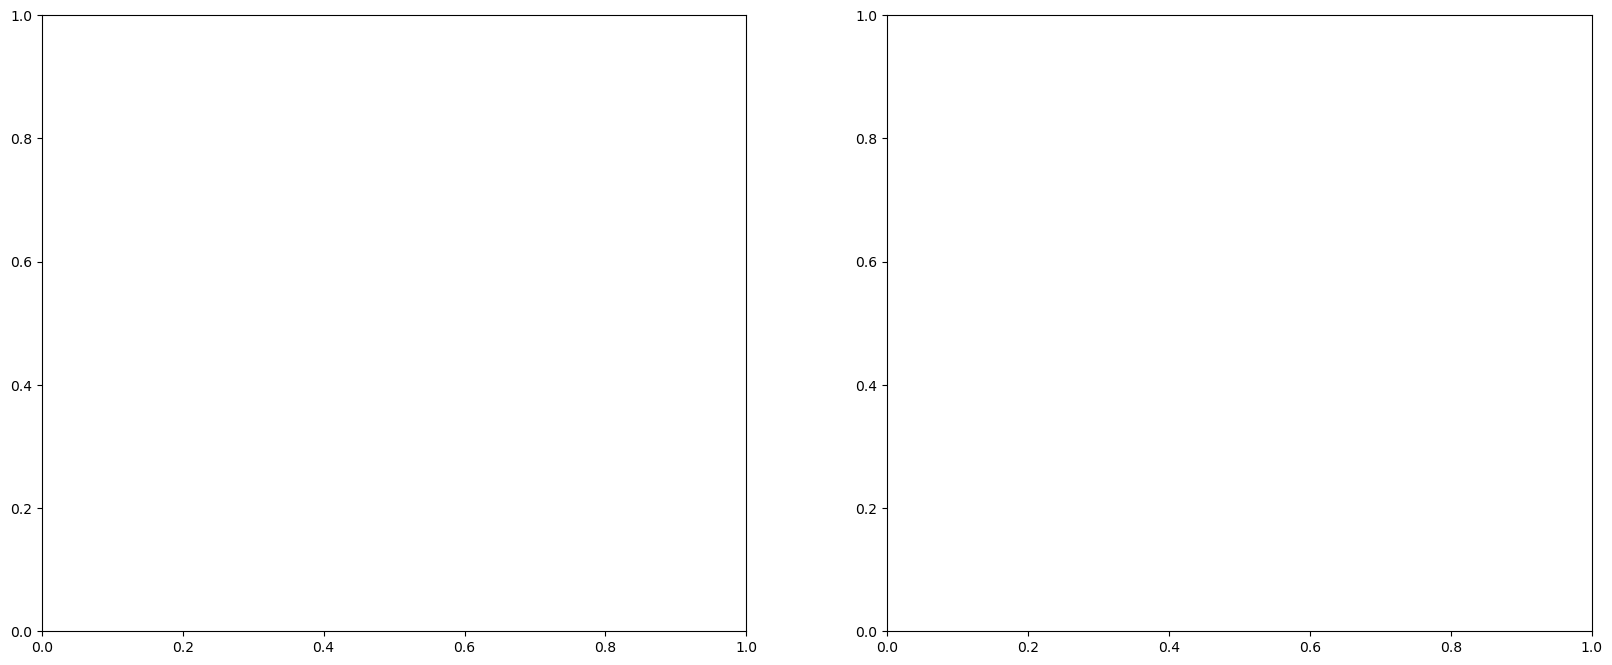

In [17]:
import matplotlib.pyplot as plt
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
hydrograph_kaub = combined_discharge_kaub[start_time_graph:first_end_time].plot(ylabel=f"[Afvoer $m^3/s$]", title=f'Hydrograph Kaub {first_year}', ax=ax1)
hydrograph_kaub.hlines(y=1200, xmin=start_time_graph, xmax=first_end_time, label='Minimum discharge Kaub', color='red', linestyle='--')
hydrograph_maxau = combined_discharge_maxau[start_time_graph:first_end_time].plot(ylabel=f"[Afvoer $m^3/s$]", title=f'Hydrograph Maxau {first_year}', ax=ax2)
hydrograph_maxau.hlines(y=2800, xmin=last_start_time, xmax=first_end_time, label='Maximum discharge Maxau', color='green', linestyle='--')
hydrograph_kaub.legend()
hydrograph_maxau.legend()
fig.tight_layout()

print(f"SSP1-2.6 scenario {first_year}: Days Maxau is above threshold in: {Maxau_ssp126_first}, days Kaub is below threshold: {Kaub_ssp126_first}")
print(f"SSP2-4.5 scenario {first_year}: Days Maxau is above threshold in: {Maxau_ssp245_first}, days Kaub is below threshold: {Kaub_ssp245_first}")
print(f"SSP5-8.5 scenario {first_year}: Days Maxau is above threshold in: {Maxau_ssp585_first}, days Kaub is below threshold: {Kaub_ssp585_first}")

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
hydrograph_kaub = combined_discharge_kaub[last_start_time:end_time].plot(ylabel=f"[Afvoer $m^3/s$]", title=f'Hydrograph Kaub {last_year}', ax=ax1)
hydrograph_kaub.hlines(y=1200, xmin=last_start_time, xmax=first_end_time, label='Minimum discharge Kaub', color='red', linestyle='--')
hydrograph_maxau = combined_discharge_maxau[last_start_time:end_time].plot(ylabel=f"[Afvoer $m^3/s$]", title=f'Hydrograph Maxau {last_year}', ax=ax2)
hydrograph_maxau.hlines(y=2800, xmin=last_start_time, xmax=end_time, label='Maximum discharge Maxau', color='green', linestyle='--')
hydrograph_kaub.legend()
hydrograph_maxau.legend()
fig.tight_layout()

print(f"SSP1-2.6 scenario {last_year}: Days Maxau is above threshold in: {Maxau_ssp126_last}, days Kaub is below threshold: {Kaub_ssp126_last}")
print(f"SSP2-4.5 scenario {last_year}: Days Maxau is above threshold in: {Maxau_ssp245_last}, days Kaub is below threshold: {Kaub_ssp245_last}")
print(f"SSP5-8.5 scenario {last_year}: Days Maxau is above threshold in: {Maxau_ssp585_last}, days Kaub is below threshold: {Kaub_ssp585_last}")

Plot hydrograph for total timespan, stripped of the first two months of spinup time

In [34]:
# Counting days that discharge is above or below critical level
start_time_obj = datetime.strptime(start_time, "%Y-%m-%d")
modified_start_time_timespan = (start_time_obj.replace(month=start_time_obj.month + 2))#.strftime("%Y-%m-%d")

timespan_maxau_ssp126 = simulated_discharge_maxau_ssp126_df[modified_start_time_timespan:end_time]
timespan_kaub_ssp126 = simulated_discharge_kaub_ssp126_df[modified_start_time_timespan:end_time]

Kaub_ssp126 = (timespan_kaub_ssp126[timespan_kaub_ssp126[f"Simulation Kaub SSP1-2.6"] < 1200].shape[0])
Maxau_ssp126 = (timespan_maxau_ssp126[timespan_maxau_ssp126[f"Simulation Maxau SSP1-2.6"] > 2800].shape[0])

timespan_maxau_ssp245 = simulated_discharge_maxau_ssp245_df[modified_start_time_timespan:end_time]
timespan_kaub_ssp245 = simulated_discharge_kaub_ssp245_df[modified_start_time_timespan:end_time]

Kaub_ssp245 = (timespan_kaub_ssp245[timespan_kaub_ssp245[f"Simulation Kaub SSP2-4.5"] < 1200].shape[0])
Maxau_ssp245 = (timespan_maxau_ssp245[timespan_maxau_ssp245[f"Simulation Maxau SSP2-4.5"] > 2800].shape[0])

timespan_maxau_ssp585 = simulated_discharge_maxau_ssp585_df[modified_start_time_timespan:end_time]
timespan_kaub_ssp585 = simulated_discharge_kaub_ssp585_df[modified_start_time_timespan:end_time]

Kaub_ssp585 = (timespan_kaub_ssp585[timespan_kaub_ssp585[f"Simulation Kaub SSP5-8.5"] < 1200].shape[0])
Maxau_ssp585 = (timespan_maxau_ssp585[timespan_maxau_ssp585[f"Simulation Maxau SSP5-8.5"] > 2800].shape[0])

SSP1-2.6 scenario: Days Maxau is above threshold in: 1199 averaging 48 days a year, days Kaub is below threshold: 
3497 averaging 140 days a year

SSP2-4.5 scenario: Days Maxau is above threshold in: 1153 averaging 46 days a year, days Kaub is below threshold: 
3849 averaging 154 days a year

SSP5-8.5 scenario: Days Maxau is above threshold in: 1298 averaging 52 days a year, days Kaub is below threshold: 
3907 averaging 156 days a year

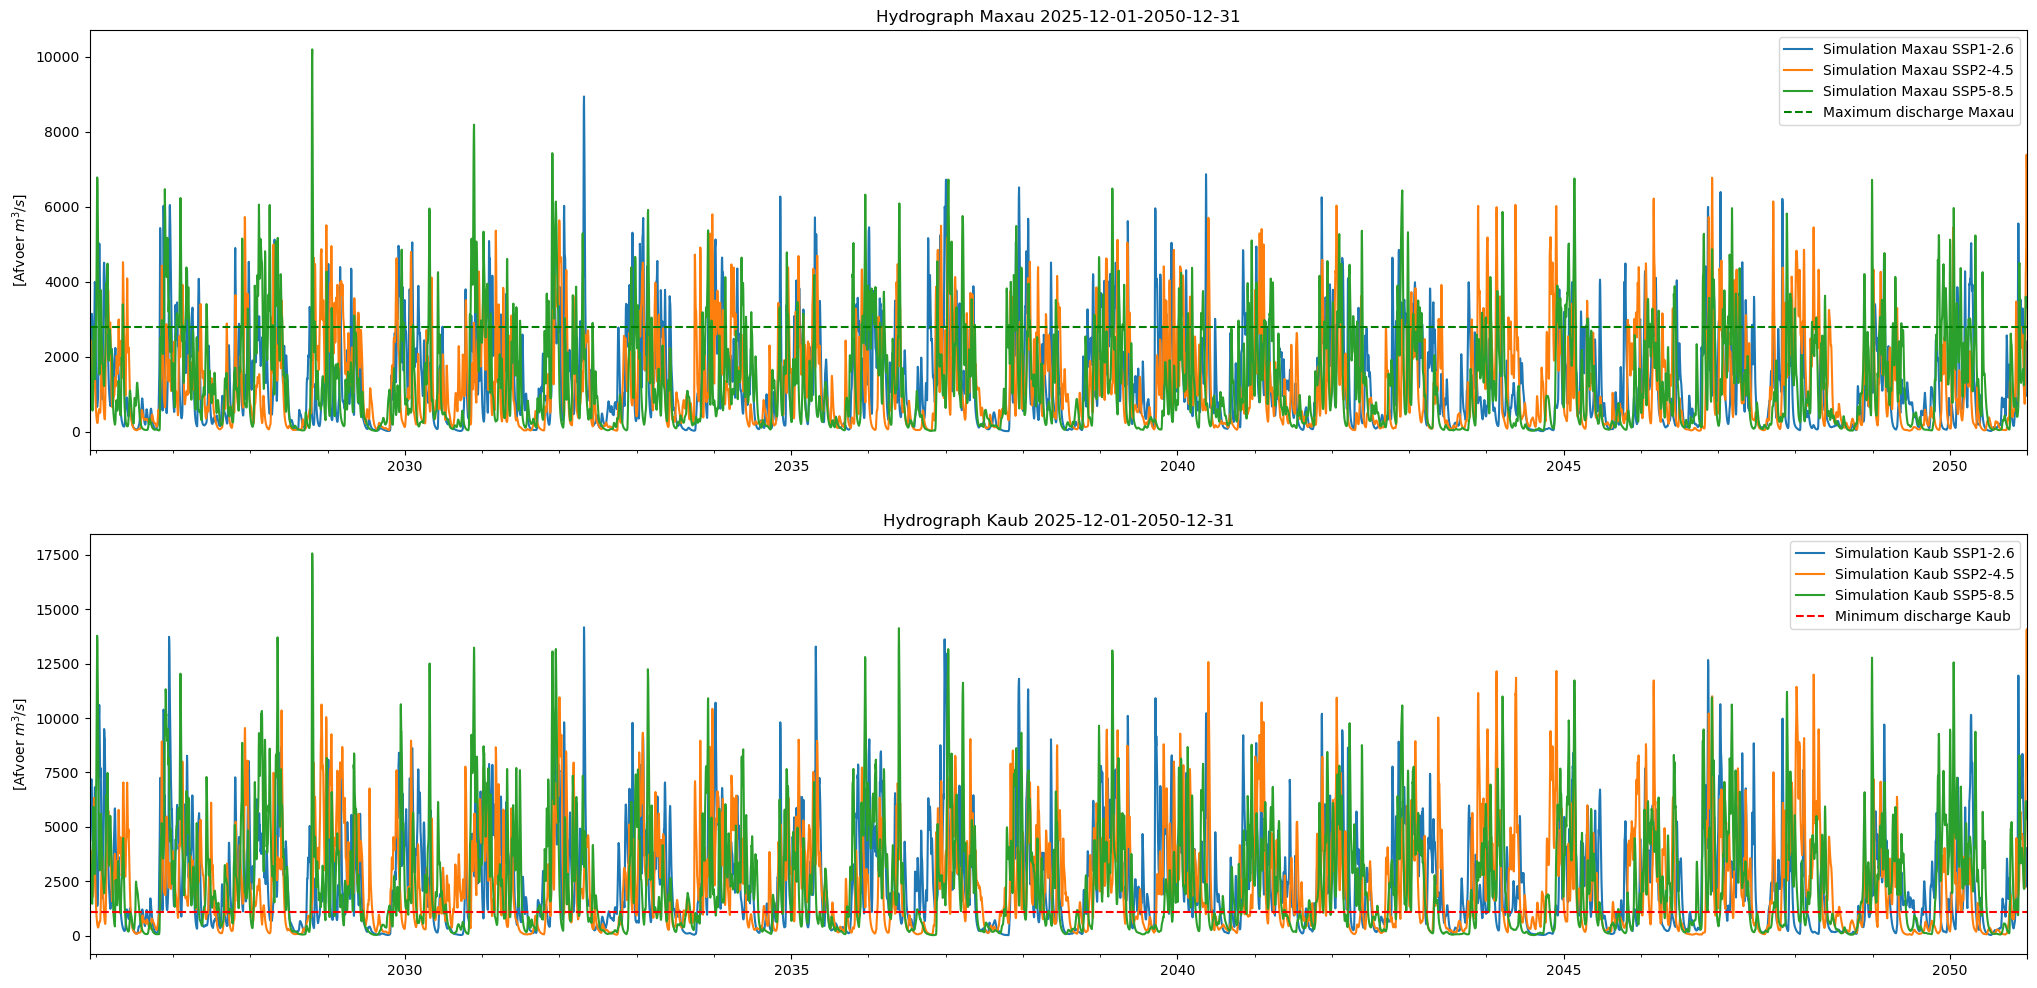

In [42]:
fig3, (ax1, ax2) = plt.subplots(2,1, figsize=(25,12))
hydrograph_kaub = combined_discharge_kaub[start_time:end_time].plot(ylabel=f"[Afvoer $m^3/s$]", title=f'Hydrograph Kaub {first_year} - {last_year}', ax=ax1)
hydrograph_kaub.hlines(y=1100, xmin=start_time, xmax=end_time, label='Minimum discharge Kaub', color='red', linestyle='--')
hydrograph_maxau = combined_discharge_maxau[start_time:end_time].plot(ylabel=f"[Afvoer $m^3/s$]", title=f'Hydrograph Maxau {first_year} - {last_year}', ax=ax2)
hydrograph_maxau.hlines(y=2800, xmin=start_time, xmax=end_time, label='Maximum discharge Maxau', color='green', linestyle='--')
hydrograph_kaub.legend()
hydrograph_maxau.legend()
fig.tight_layout()

# Count total timespan:
start_date = datetime.strptime(start_time, "%Y-%m-%d")
end_date = datetime.strptime(end_time, "%Y-%m-%d")

# Add two months to the start date
adjusted_start_date = start_date + relativedelta(months=2)

# Calculate the difference in years
timespan_years = (end_date.year - adjusted_start_date.year) - ((end_date.month, end_date.day) < (adjusted_start_date.month, adjusted_start_date.day))

print(f"SSP1-2.6 scenario: Days Maxau is above threshold in: {Maxau_ssp126} averaging {(Maxau_ssp126 / timespan_years):.0f} days a year, days Kaub is below threshold: {Kaub_ssp126} averaging {(Kaub_ssp126 / timespan_years):.0f} days a year")
print(f"SSP2-4.5 scenario: Days Maxau is above threshold in: {Maxau_ssp245} averaging {(Maxau_ssp245 / timespan_years):.0f} days a year, days Kaub is below threshold: {Kaub_ssp245} averaging {(Kaub_ssp245 / timespan_years):.0f} days a year")
print(f"SSP5-8.5 scenario: Days Maxau is above threshold in: {Maxau_ssp585} averaging {(Maxau_ssp585 / timespan_years):.0f} days a year, days Kaub is below threshold: {Kaub_ssp585} averaging {(Kaub_ssp585 / timespan_years):.0f} days a year")

## River runoff on the Rhine

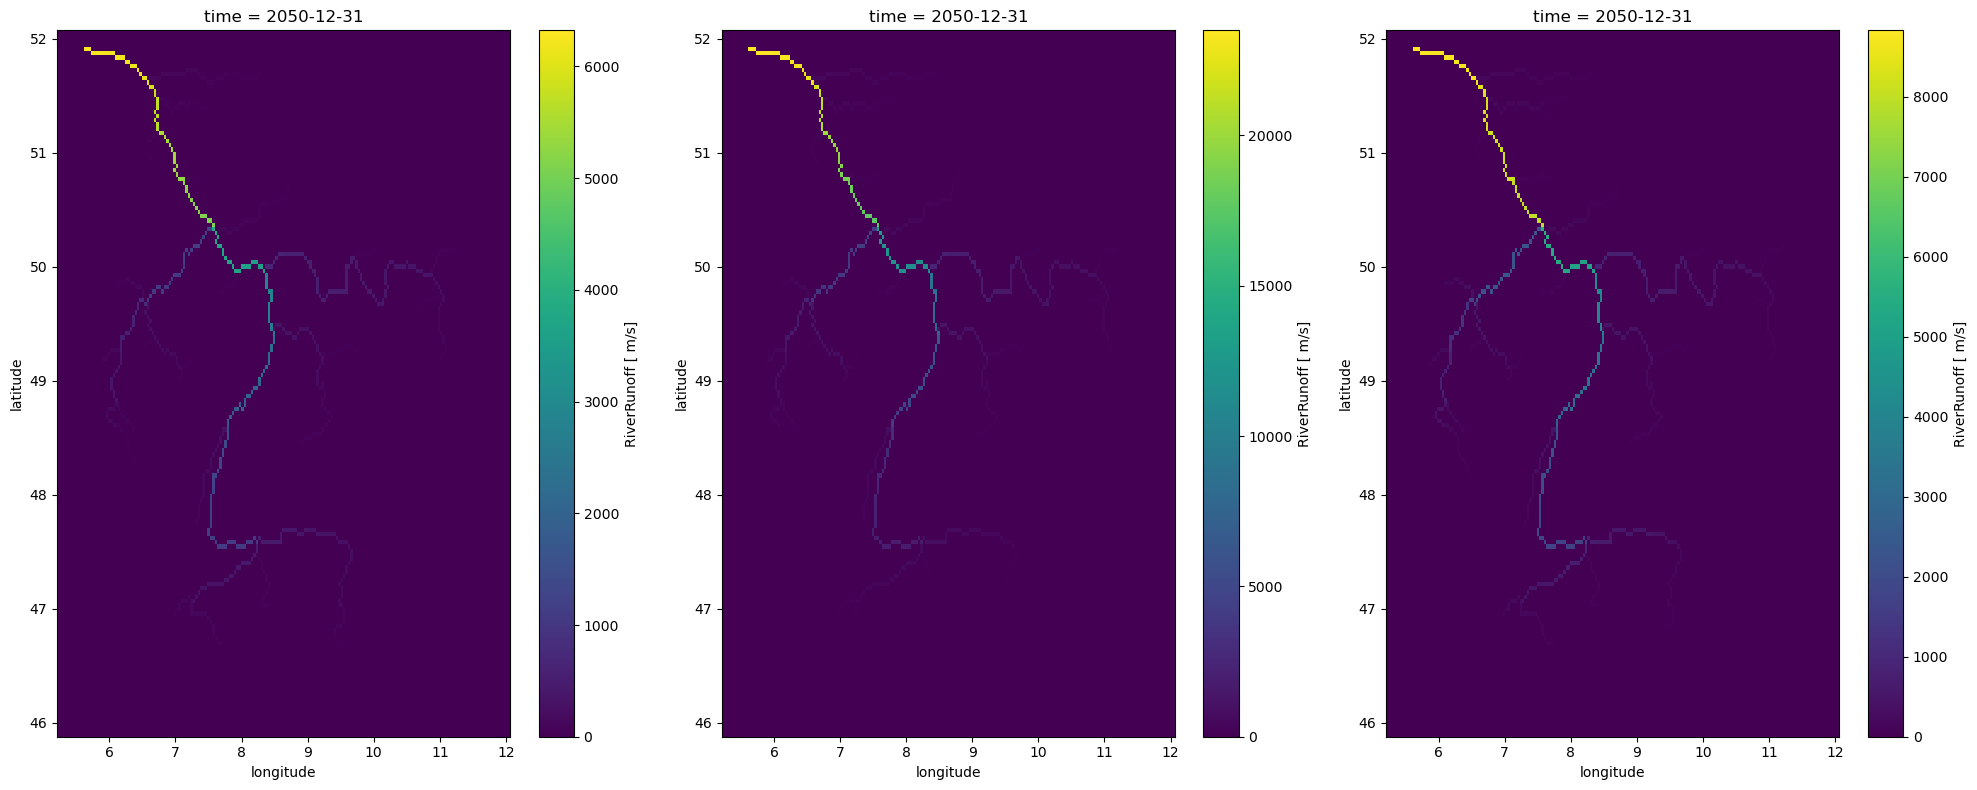

In [18]:
fig2, (sssp126, sssp245, sssp585) = plt.subplots(1,3, figsize=(20, 8))
sssp126 = models['model_ssp126'].get_value_as_xarray('RiverRunoff').isel(time=0).plot(ax=sssp126)
sssp245 = models['model_ssp245'].get_value_as_xarray('RiverRunoff').isel(time=0).plot(ax=sssp245)
sssp585 = models['model_ssp585'].get_value_as_xarray('RiverRunoff').isel(time=0).plot(ax=sssp585)
fig2.tight_layout()

In [84]:
models['model_ssp126'].finalize()
models['model_ssp245'].finalize()
models['model_ssp585'].finalize()

In [30]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


start_time = datetime.strptime(start_time, "%Y-%m-%d")
end_time = datetime.strptime(end_time, "%Y-%m-%d")
start_time = start_time + relativedelta(months=2)
print(start_time, end_time)

first_end_time = start_time + relativedelta(years=1) - relativedelta(days=1)
print(start_time, first_end_time)

last_start_time = end_time - relativedelta(years=1) + relativedelta(days=1)


2025-01-01 00:00:00 2050-12-31 00:00:00

2025-01-01 00:00:00 2025-12-31 00:00:00

2050-01-01 00:00:00 2050-12-31 00:00:00

In [17]:
modified_start_time_last = (datetime.strptime(end_time, "%Y-%m-%d").replace(year=datetime.strptime(end_time, "%Y-%m-%d").year - 1))
modified_start_time_first = (datetime.strptime(start_time, "%Y-%m-%d").replace(month=datetime.strptime(start_time, "%Y-%m-%d").month + 2))
modified_end_time_first = (datetime.strptime(end_time, "%Y-%m-%d").replace(year=datetime.strptime(end_time, "%Y-%m-%d").month + 2))
print(modified_start_time_last, end_time,modified_start_time_first,modified_end_time_first)

ValueError: unconverted data remains: T00:00:00Z